## Redes Neurais Artificiais 2020.1

**Disciplina**: Redes Neurais Artificiais 2020.1  
**Professora**: Elloá B. Guedes (ebgcosta@uea.edu.br)  
**Github**: http://github.com/elloa  
        

Levando em conta a base de dados **_Forest Cover Type_**, esta terceira parte do Projeto Prático 3 diz respeito à proposição e avaliação de múltiplas redes neurais artificiais do tipo feedforward multilayer perceptron para o problema da classificação multi-classe da cobertura florestal em uma área do Roosevelt National Forest.

## Testando Redes Neurais sem os Atributos Categórios

1. Abra a base de dados em questão
2. Elimine todas as colunas relativas aos atributos categóricos
3. Armazene o atributo alvo em uma variável y e os atributos preditores em uma variável X
4. Efetue uma partição holdout 70/30 com o sklearn, distribuindo os exemplos de maneira aleatória
5. Efetue o escalonamento dos atributos

### Escalonando os atributos

O treinamento de uma rede neural artificial é mais eficiente quando os valores que lhes são fornecidos como entrada são pequenos, pois isto favorece a convergência. Isto é feito escalonando-se todos os atributos para o intervalo [0,1], mas precisa ser feito de maneira cautelosa, para que informações do conjunto de teste não sejam fornecidas no treinamento.

Há duas estratégias para tal escalonamento: normalização e padronização. Ambas possuem características particulares, vantagens e limitações, como é possível ver aqui: https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/


No nosso caso, vamos usar a padronização. Assim, com os atributos preditores do treinamento, isto é, X_train, deve-se subtrair a média e dividir pelo desvio padrão:

X_train_std = (X_train - np.mean(X_train))/np.std(X_train)

Em seguida, o mesmo deve ser feito com os atributos preditores do conjunto de testes, mas com padronização relativa ao conjunto de treinamento:

X_test_std = (X_test - np.mean(X_train))/np.std(X_train)

Se todo o conjunto X for utilizado na padronização, a rede neural receberá informações do conjunto de teste por meio da média e variância utilizada para preparar os dados de treinamento, o que não é desejável.


### Continuando

5. Treine uma rede neural multilayer perceptron para este problema com uma única camada e dez neurônios  
    5.1 Utilize a função de ativação ReLU  
    5.2 Utilize o solver Adam    
    5.3 Imprima o passo a passo do treinamento    
    5.4 Utilize o número máximo de épocas igual a 300  
6. Com o modelo em questão, após o treinamento, apresente:  
    6.1 Matriz de confusão para o conjunto de teste  
    6.2 Acurácia  
    6.3 F-Score  
    6.4 Precisão  
    6.5 Revocação  
7. Repita o treinamento da mesma rede anterior sem imprimir o passo a passo (verbose False) por 100 vezes  
    7.1 Cada uma destas repetições deve ser feita com uma nova partição Holdout  
    7.2 Apresente a média e o desvio padrão da acurácia e do F-Score para o conjunto de treino  
8. Repita por 100 vezes o treinamento desta mesma rede, mas utilizando o otimizador SGD  
    8.1 Apresente a média e o desvio padrão da acurácia e do F-Score para o conjunto de treino  
9. Houve influência da escolha do otimizador no desempenho da rede?

In [24]:
#começando com os imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns

import warnings
#isso é para ignorar os warnings dizendo que a rede atingiu o numero maximo de iterações e não convergiu
warnings.filterwarnings('ignore') 

### Classes e funções que serão utilizadas durante os testes

In [25]:
#classe para padronizar os dados
class standardizer:
    def __init__(self):
        self.mean = None
        self.std = None
        
    def fit(self, data):
        if self.mean is not None or self.std is not None:
            print('Overwriting previous state!')
        self.mean = np.mean(data)
        self.std = np.std(data)
        
    def transform(self, data):
        if self.mean is None or self.std is None:
            raise Exception('Standardizer not yet fit on any data!')
        
        return (data - self.mean)/self.std
    
    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

In [26]:
#para otimizar os treinamentos e testes de hiperparametros, sera utilizada a seguinte função, que servirá como jig de testes.

def automate_nn_test(config, activation, solver, epochs, data, label, return_cm = False, reps = 1, get_train_metrics = False):
    """
    Parameters
    ----------
    config : tuple
        Tupla contendo a configuração que será utilizada na rede
    activation : string
        Um de 'identity', 'logistic', 'tanh', 'relu'
    solver : string
        Um de 'lbfgs', 'sgd', 'adam'
    epochs : int
        Quantidade máxima de épocas para treinar o modelo. Há paciência de epochs//4 para o treinamento.
    data : np.array
        Dados utilizados para o treinamento
    label : np.array
        Rótulo de cada uma das entradas
    return_cm : boolean
        Para retornar ou não a matriz de confusão
    reps : int
        Quantidade de vezes que o modelo será retreinado. Cada vez é realizado um novo split dos dados
    get_train_metrics : boolean
        Define se as métricas de avaliação serão calculadas com base no set de treino ou no set de teste. Default = False
    """
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    for instance in range(reps):
        #split
        x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.3)
        #instanciação e treinamento do modelo
        model = MLPClassifier(hidden_layer_sizes = config, activation = activation, solver=solver, max_iter = epochs, n_iter_no_change = epochs//4, verbose = False)
        model.fit(x_train, y_train)
        #previsão para adquirir métricas
        if get_train_metrics:
            metric_data = x_train
            metric_label = y_train
        else:
            metric_data = x_test
            metric_label = y_test
        y_pred = model.predict(metric_data)
        accuracy_scores.append(sklearn.metrics.accuracy_score(metric_label, y_pred))
        precision_scores.append(sklearn.metrics.precision_score(metric_label, y_pred, labels = np.unique(metric_label), average = 'macro'))
        recall_scores.append(sklearn.metrics.recall_score(metric_label, y_pred, labels = np.unique(metric_label), average = 'macro'))
        f1_scores.append(sklearn.metrics.f1_score(metric_label, y_pred, labels = np.unique(metric_label), average = 'macro'))
        if instance%5 == 0:
            print('Done with first '+str(instance))
    #para manter em disco.
    np.save('../npys/metrics'+activation+'_'+solver+'_'+str(reps)+'.npy',[accuracy_scores, precision_scores, recall_scores, f1_scores])
    return accuracy_scores, precision_scores, recall_scores, f1_scores

## Primeira parte - Treinamento de uma rede, sem os atributos categóricos

In [27]:
#carregando a base...
df = pd.read_csv('../data/covtype.csv')
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [28]:
#eliminando todas as colunas referentes a atributos categóricos, ou sejaos tipos de solo e area selvagem
df_nocat = df.drop([('Wilderness_Area' + str(i)) for i in range(1, 5)] + [('Soil_Type'+ str(i)) for i in range(1, 41)], axis = 1)
#separando os atributos preditores do atributo alvo
x = df_nocat.drop(['Cover_Type'],axis = 1)
y = df_nocat['Cover_Type']

In [22]:
#split dos dados entre subset de treino e de teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=42)

In [23]:
#instanciação da classe + transformação dos dados
scaler = standardizer()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [7]:
#rede neural
epochs = 300
solver = 'adam'
activation = 'relu'
config = (10)
model = MLPClassifier(hidden_layer_sizes=config, activation=activation, solver=solver, verbose=True, max_iter=epochs, n_iter_no_change = epochs//4).fit(x_train, y_train)

Iteration 1, loss = 0.93029850
Iteration 2, loss = 0.70711205
Iteration 3, loss = 0.68445190
Iteration 4, loss = 0.67344485
Iteration 5, loss = 0.66791722
Iteration 6, loss = 0.66493443
Iteration 7, loss = 0.66298709
Iteration 8, loss = 0.66152817
Iteration 9, loss = 0.66018709
Iteration 10, loss = 0.65907305
Iteration 11, loss = 0.65804401
Iteration 12, loss = 0.65736443
Iteration 13, loss = 0.65655983
Iteration 14, loss = 0.65593022
Iteration 15, loss = 0.65543205
Iteration 16, loss = 0.65486805
Iteration 17, loss = 0.65455475
Iteration 18, loss = 0.65413048
Iteration 19, loss = 0.65383958
Iteration 20, loss = 0.65345729
Iteration 21, loss = 0.65338992
Iteration 22, loss = 0.65306329
Iteration 23, loss = 0.65289115
Iteration 24, loss = 0.65278843
Iteration 25, loss = 0.65257857
Iteration 26, loss = 0.65253647
Iteration 27, loss = 0.65236714
Iteration 28, loss = 0.65233058
Iteration 29, loss = 0.65216998
Iteration 30, loss = 0.65219723
Iteration 31, loss = 0.65212979
Iteration 32, los

Iteration 253, loss = 0.64453128
Iteration 254, loss = 0.64446825
Iteration 255, loss = 0.64440098
Iteration 256, loss = 0.64437570
Iteration 257, loss = 0.64434104
Iteration 258, loss = 0.64454538
Iteration 259, loss = 0.64435877
Iteration 260, loss = 0.64438074
Iteration 261, loss = 0.64443318
Iteration 262, loss = 0.64437756
Iteration 263, loss = 0.64426555
Iteration 264, loss = 0.64444659
Iteration 265, loss = 0.64429495
Iteration 266, loss = 0.64430407
Iteration 267, loss = 0.64433106
Iteration 268, loss = 0.64430896
Iteration 269, loss = 0.64414499
Iteration 270, loss = 0.64416020
Iteration 271, loss = 0.64419524
Iteration 272, loss = 0.64418776
Iteration 273, loss = 0.64415765
Iteration 274, loss = 0.64423806
Iteration 275, loss = 0.64425981
Iteration 276, loss = 0.64418023
Iteration 277, loss = 0.64423690
Iteration 278, loss = 0.64424272
Iteration 279, loss = 0.64416102
Iteration 280, loss = 0.64418637
Iteration 281, loss = 0.64409210
Iteration 282, loss = 0.64405039
Iteration 

C:\Users\luido\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(7.0, 0.0)

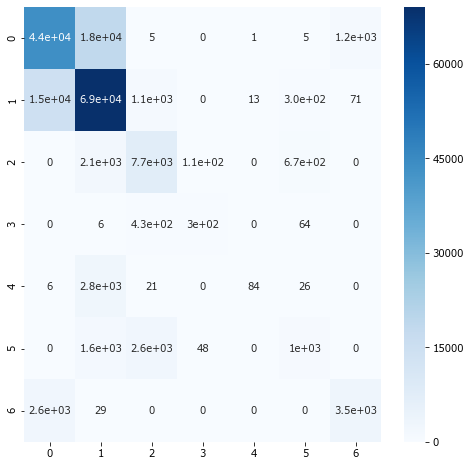

In [21]:
#métricas
y_pred = model.predict(x_test)
cf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', normalize='true')
# ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [46]:
acc = sklearn.metrics.accuracy_score(y_test, y_pred)
prec = sklearn.metrics.precision_score(y_test, y_pred, labels = np.unique(y_test), average = 'macro')
rec = sklearn.metrics.recall_score(y_test, y_pred, labels = np.unique(y_test), average = 'macro')
f1 = sklearn.metrics.f1_score(y_test, y_pred, labels = np.unique(y_test), average = 'macro')

print('As métricas para esta configuração do modelo foram:\nAcurácia: {}\nPrecisao: {}\nRevocacao: {}\nF1-Score: {}'.format(acc, prec, rec, f1))

As métricas para esta configuração do modelo foram:
Acurácia: 0.7203621259408849
Precisao: 0.6906835567966105
Revocacao: 0.48586131133125426
F1-Score: 0.5166304941323746


# Nesta parte, é testada as mudanças que o solver pode causar no treinamento.

Para mostrar essa diferença, as métricas refletem o processo de treinamento, ao invés de utilizar o set de treino, que é normalmente utilizado para avaliar a qualidade da rede. Sendo assim, o principal objetivo desta parte é avaliar o próprio processo de treinamento.

## Usando o solver Adam

In [45]:
epochs = 300
solver = 'adam'
activation = 'relu'
config = (10)
accuracy_scores, precision_scores, recall_scores, f1_scores = automate_nn_test(config, activation, solver, epochs,  x, y, reps = 15, get_train_metrics = True)

Done with first 0
Done with first 5
Done with first 10


In [51]:
print('As métricas, em média e desvio padrão, para esta configuração do modelo foram:\nAcurácia média: {:.2f}+-{:.2f}\nF1-Score médio: {:.2f}+-{:.2f}'.format(
    np.mean(accuracy_scores), np.std(accuracy_scores), np.mean(f1_scores), np.std(f1_scores)))

As métricas, em média e desvio padrão, para esta configuração do modelo foram:
Acurácia média: 0.70+-0.01
F1-Score médio: 0.46+-0.04


## Usando o solver SGD

In [53]:
epochs = 300
solver = 'sgd'
activation = 'relu'
config = (10)
accuracy_scores, precision_scores, recall_scores, f1_scores = automate_nn_test(config, activation, solver, epochs, x, y, reps = 15, get_train_metrics = True)

Done with first 0
Done with first 5
Done with first 10


In [54]:
print('As métricas, em média e desvio padrão, para esta configuração do modelo foram:\nAcurácia média: {:.2f}+-{:.2f}\nF1-Score médio: {:.2f}+-{:.2f}'.format(
    np.mean(accuracy_scores), np.std(accuracy_scores), np.mean(f1_scores), np.std(f1_scores)))

As métricas, em média e desvio padrão, para esta configuração do modelo foram:
Acurácia média: 0.49+-0.00
F1-Score médio: 0.09+-0.00


# Conclusão entre os dois resultados

## Discussão

Nos passos anteriores, você avaliou o desempenho de uma única rede neural que contém os seguintes parâmetros: uma única camada oculta com 10 neurônios e função de ativação ReLU. O otimizador utilizado, quer seja SGD ou ADAM, trata-se do algoritmo para aproximar o gradiente do erro. Neste sentido, a escolha do otimizador é um hiperparâmetro, pois diz respeito a como a rede neural definida previamente atuará "em tempo de execução"  durante o processo de treinamento. Também são hiperparâmetros a quantidade de épocas, a taxa de aprendizado inicial, dentre outros.

Cabe salientar também que você efetuou o treinamento desta rede por 100 vezes e apresentou os resultados em termos de média +- desvio padrão. Lembre-se que em uma rede neural há a inicialização aleatória de pesos e, em consequência, o desempenho delas está sujeito à uma flutuação estocástica. A execução destas múltiplas vezes faz com que eliminemos algum viés introduzido por uma boa ou má "sorte" na escolha de pesos no caso de uma única execução.

Você também aprendeu uma estratégia para escalonar os atributos para uma melhor convergência da rede. Utilize-a em todos os treinamentos e testes propostos a seguir.

## Propondo Novas Arquiteturas

Variando  os parâmetros (uma ou duas camadas ocultas, com diferente números de neurônios em cada uma delas e a função de ativação) e o hiperparâmetros solver (Adam ou SGD) e o número de épocas (100,150 e 200), atenda ao que se pede:

1. Proponha 10 arquiteturas distintas de RNAs para o problema em questão, à sua escolha
2. Avalie cada uma das arquiteturas perante todos os hiperparâmetros apresentados por 100 vezes
3. Como resultado da avaliação, apresente:  
    3.1 Top-3 melhores redes no tocante à F-Score e Acurácia  
    3.2 Repetição em que houve o melhor desempenho de cada uma dessas redes: ilustre tp, tf, fp e fn  

## Estimando o número de neurônios

Um dos problemas de pesquisa com redes neurais artificiais consiste na determinação do número de neurônios em sua arquitetura. Embora não seja possível definir a priori qual rede neural é adequada para um problema, pois isto só é possível mediante uma busca exaustiva, há regras na literatura que sugerem o número de neurônios escondidos, tal como a regra da Pirâmide Geométrica, dada a seguir:

$$N_h = \alpha \cdot \sqrt{N_i \cdot N_o},$$

em que $N_h$ é o número de neurônios ocultos (a serem distribuídos em uma ou duas camadas ocultas), $N_i$ é o número de neurônios na camada de entrada e $N_o$ é o número de neurônios na camada de saída. 

1. Consulte a documentação da classe MLPClassifier (disponível em https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) e obtenha os valores de $N_i$ e $N_h$.
2. Teste os valores de $\alpha$ como sendo iguais a $0.5$, $2$ e $3$.
3. Proponha pelo menos 30 redes neurais segundo a regra da pirâmide geométrica e teste-as nos mesmos termos estabelecidos anterioremente  (solver, épocas, etc.)  
    3.1 Apresente as top-3 melhores redes no tocante à F-Score e Acurácia  

In [38]:
No = len(df.groupby('Cover_Type'))
Ni = len(df_nocat.columns)
Nh = 100 # padrão do MLPClassifier

print("No: " + str(No))
print("Ni: " + str(Ni))
print("Nh: " + str(Nh) + " (MLPClassifier)")

def get_hidden_layers_size(input_size, output_size, alpha):
    return int(alpha * ((input_size * output_size) ** (1/2)))

def get_config(hidden_size, hidden_layers):
    if hidden_layers == 1:
        return (hidden_size,)
    l0 = int(hidden_size/hidden_layers)
    return (l0, hidden_size - l0)

alphas = [0.5, 2, 3]
solvers = ['adam', 'sgd']
hidden_layers = [1, 2]

configurations = []
print("\nConfigurações: ")
print("--------------------------------------")
print("(alpha, solver, hidden_layers, epochs)")
print("--------------------------------------")

i = 0
for a in alphas:
    for s in solvers:
        for h in hidden_layers:
            epochs = [150, 200]
            if s == 'adam':
                epochs = [100, 200]
            
            for e in epochs:
                configurations.append((a, s, h, e))
                print(configurations[-1])
        e = 100
        if s == 'adam':
            e = 150
        configurations.append((a, s, hidden_layers[i % 2], e))
        print(configurations[-1])
    i += 1

No: 7
Ni: 11
Nh: 100 (MLPClassifier)

Configurações: 
--------------------------------------
(alpha, solver, hidden_layers, epochs)
--------------------------------------
(0.5, 'adam', 1, 100)
(0.5, 'adam', 1, 200)
(0.5, 'adam', 2, 100)
(0.5, 'adam', 2, 200)
(0.5, 'adam', 1, 150)
(0.5, 'sgd', 1, 150)
(0.5, 'sgd', 1, 200)
(0.5, 'sgd', 2, 150)
(0.5, 'sgd', 2, 200)
(0.5, 'sgd', 1, 100)
(2, 'adam', 1, 100)
(2, 'adam', 1, 200)
(2, 'adam', 2, 100)
(2, 'adam', 2, 200)
(2, 'adam', 2, 150)
(2, 'sgd', 1, 150)
(2, 'sgd', 1, 200)
(2, 'sgd', 2, 150)
(2, 'sgd', 2, 200)
(2, 'sgd', 2, 100)
(3, 'adam', 1, 100)
(3, 'adam', 1, 200)
(3, 'adam', 2, 100)
(3, 'adam', 2, 200)
(3, 'adam', 1, 150)
(3, 'sgd', 1, 150)
(3, 'sgd', 1, 200)
(3, 'sgd', 2, 150)
(3, 'sgd', 2, 200)
(3, 'sgd', 1, 100)


In [30]:
metrics_list = []

i = 0
for alpha, solver, hidden_layers, epochs in configurations:
    Nh = get_hidden_layers_size(Ni, No, alpha)
    config = get_config(Nh, hidden_layers)
    
    a,p,r,f = automate_nn_test(config, 'relu', solver, epochs, x, y, reps = 100)
    metrics_list.append((a,p,r,f))

    i += 1
    if i % 5 == 0:
        print("Concluiu " + str(i) + " configurações")

NameError: name 'sklearn' is not defined

In [36]:
f1_scores = np.array([np.mean(f) for (a,p,r,f) in metrics_list])

f1_order_indexes = np.flip(np.argsort(f1_scores))

print("Configurações com melhor F-Score médio:")
print("------------------------------------------------")
print("(alpha, solver, hidden_layers, epochs) = F-Score")
print("------------------------------------------------")

best_pyramid_configs = []
for i in f1_order_indexes[:3]:
    print(str(configurations[i]) + " = " + str(f1_scores[i]))
    best_pyramid_configs.append(configurations[i])

Configurações com melhor F-Score médio:
------------------------------------------------
(alpha, solver, hidden_layers, epochs) = F-Score
------------------------------------------------
(0.5, 'adam', 1, 150) = 7
(0.5, 'adam', 2, 100) = 5
(0.5, 'adam', 1, 200) = 4


## Testando as Redes Neurais com Atributos Categóricos

1. Considere as 6 redes neurais obtidas nos dois top-3 anteriores (arquiteturas próprias e regra da pirâmide geométrica)
2. Com todos os atributos preditores da base de dados original, incluindo os categóricos, treine e teste estas mesmas redes por 100 repetições  
    2.1 Considere o melhor otimizador para cada uma delas  
    2.2 Faça uso de 200 épocas para treinamento  
    2.2 Apresente os resultados de acurácia e F-Score em termos da média +- dp para cada arquitetura
3. Apresente o gráfico boxplot para o F-Score das 6 arquiteturas perante as 100 repetições

In [39]:
# Configurações para os dois top 3 (hidden_layers, solver, epochs)
top = []
top_pyramid = []

all_x = df.drop(['Cover_Type'], axis = 1)
all_y = df['Cover_Type']

metrics = []
metrics_pyramid = []

for hidden_layers, solver, epochs in top:
    a,p,r,f = automate_nn_test(hidden_layers, 'relu', 'adam', 200, all_x, all_y, reps = 100)
    metrics.append((a,p,r,f))

for hidden_layers, solver, epochs in top_pyramid:
    a,p,r,f = automate_nn_test(hidden_layers, 'relu', 'adam', 200, all_x, all_y, reps = 100)
    metrics_pyramid.append((a,p,r,f))

In [88]:
print("Arquiteturas próprias:")
print("-------------------------------------------------")
print("Camadas ocultas : Acurácia média ; F-Score médio")
print("-------------------------------------------------")

for (hidden_layers, solver, epochs), (a, p, r, f) in zip(top, metrics):
    print('{}: {:.2f}+-{:.2f} ; {:.2f}+-{:.2f}'.format(hidden_layers, np.mean(a), np.std(a), np.mean(f), np.std(f)))

print("\n\nArquiteturas seguindo pirâmide geométrica:")
print("-------------------------------------------------")
print("Camadas ocultas : Acurácia média ; F-Score médio")
print("-------------------------------------------------")

for (hidden_layers, solver, epochs), (a, p, r, f) in zip(top_pyramid, metrics_pyramid):
    print('{}: {:.2f}+-{:.2f} ; {:.2f}+-{:.2f}'.format(hidden_layers, np.mean(a), np.std(a), np.mean(f), np.std(f)))

Arquiteturas próprias:
-------------------------------------------------
Camadas ocultas : Acurácia média ; F-Score médio
-------------------------------------------------
(1,): 1.00+-0.00 ; 4.00+-0.89


Arquiteturas seguindo pirâmide geométrica:
-------------------------------------------------
Camadas ocultas : Acurácia média ; F-Score médio
-------------------------------------------------
(2,): 1.00+-0.00 ; 4.00+-0.89


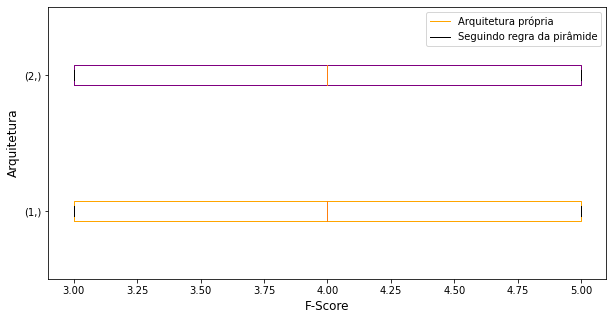

In [97]:
# Boxplot das métricas

f_scores = [f for (a,p,r,f) in metrics]
f_scores_pyramid = [f for (a,p,r,f) in metrics_pyramid]

def interpolate(list_a, list_b):
    res = []
    for a,b in zip(list_a, list_b):
        res.append(a)
        res.append(b)
    return res

label_list = [str(h) for (h,s,e) in top]
label_list_pyramid = [str(h) for (h,s,e) in top_pyramid]

positions = [i for i in range(0, len(label_list) * 2, 2)]
positions_pyramid = [p + 1 for p in positions]

plt.figure(figsize=(10,5))
plt.xlabel('F-Score', fontsize=12)
plt.ylabel('Arquitetura',fontsize=12)

box_props = dict(color='orange')
bx1 = plt.boxplot(f_scores, labels=label_list, positions=positions, vert=False, boxprops=box_props)

box_props = dict(color='purple')
bx2 = plt.boxplot(f_scores_pyramid, labels=label_list_pyramid, positions=positions_pyramid, vert=False, boxprops=box_props)

plt.legend(['Arquitetura própria', 'Seguindo regra da pirâmide'])

## Considerações Parciais

1. É possível identificar uma rede com desempenho superior às demais?
2. Qual estratégia mostrou-se mais producente para a obtenção de boas arquiteturas (Estratégia Própria ou Pirâmide Geométrica)? Por quê?
3. Considerar os atributos categóricos trouxe melhorias? Justifique.
4. Um número maior de épocas trouxe melhorias?
5. Qual a maior dificuldade de resolução do problema proposto perante as RNAs?